# LED Data Analysis Using Tool Functions
## Import the Libraries

In [1]:
import sys,os
import time 
import h5py

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.special import expit

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
import MB_equations as MBe
import MB_analysis as MBa
import TimestreamHelperFunctions as Thf
import OptFilterTools as oft

## Define the MB Parameters

In [2]:
## MB Results come from fitting a temperature scan at a specified RF power
use_nexus_MBvals = False

if use_nexus_MBvals:
    ## As measured in NEXUS
    MB_fit_vals = np.array([4.24216+9.75e-6, 
                            0.177  ,
                            0.0125 ,
                            4.1e7  ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
else:
    ## As measured on Caltech sister device (https://arxiv.org/pdf/2111.08064.pdf)
    MB_fit_vals = np.array([4.24201000, 
                            0.184     ,
                            0.03801   ,
                            4.05538e5 ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
    
## How much attenuation is in the lines before the chip
line_atten_dB = 56.5

## Define the PSD Parameters

In [3]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e1
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.1

## Removal decimation for cleaning (more == better high-F cleaning)
removal_dec    = 10

## Pull the Data Files

In [4]:
datapath = '/data/USRP_Laser_Data'
series   = "20230713_152558" # "20230215_101743"

sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

n_runs   = len(led_files)
for f in nse_files:
    print(f)

/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_11.h5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_14.h5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_2.h5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_5.h5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_8.h5


## Extract Voltage and Pulse Profile Information

In [5]:
voltages, p_params, charFs, charZs = oft.parse_metadata(sum_file, 
                                                        blank_fraction=blank_fraction, 
                                                        verbose=True)

RF Power at USRP: -15 dBm
Char. freqs:  [[4241.950653 4241.951542 4241.95243 ]
 [4241.950653 4241.951542 4241.95243 ]
 [4241.950653 4241.951542 4241.95243 ]
 [4241.950653 4241.951542 4241.95243 ]
 [4241.950653 4241.951542 4241.95243 ]
 [4241.950653 4241.951542 4241.95243 ]]
Char. S21s:   [[0.14956476+0.08013122j 0.1498773 +0.08678613j 0.14890199+0.09287615j]
 [0.15040469+0.07583644j 0.15012718+0.08261491j 0.14908874+0.09027844j]
 [0.1494241 +0.07613812j 0.14886481+0.08330118j 0.14855173+0.09001141j]
 [0.14935637+0.0757731j  0.14845795+0.08317396j 0.14821089+0.0906626j ]
 [0.14941679+0.07604463j 0.14836464+0.08355995j 0.14830992+0.09014706j]
 [0.14901095+0.0768632j  0.14810257+0.08433052j 0.14803194+0.09122225j]]
Duration: 200.0 sec
Pulse f:  5.0 Hz
Pls wdth: 2.0 us
P  delay: 5.0 ms
Total pulse windows in acq.:  1000.0
Time between pulse arrival:   0.2 sec
Number of windows to look at: 900


## Noise Cleaning and PSDs

In [6]:
for i in np.arange(len(nse_files)):
    powers, PSDs, res, timestreams = Thf.CleanPSDs(nse_files[i], vna_file, 
        PSD_lo_f=chunk_up_to, 
        PSD_hi_f=decimate_down_to, 
        rem_dec=removal_dec,
        f_transient=blank_fraction, 
        charFs=charFs[i].real, 
        charZs=charZs[i],
        show_plots=False, verbose=False)

pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5 because override=True!
found 1 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_11.h5 because override=True!
found 6 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0_11_cleaned.h5 because override=True!
Converting to resonator basis!
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_Dat

## Define the Files To Process

In [7]:
## Look at phase or log-mag
PHASE = True

files_to_skip = 0 ## How many to skip at beginning
files_to_trim = 0 ## How many to cut off at end

# LED_files = led_files[files_to_skip:n_runs-files_to_trim]
# Voltages  = voltages[files_to_skip:n_runs-files_to_trim]

LED_files = led_files[::2]
Voltages  = voltages[::2]

LED_files = LED_files[Voltages != 5.50]
Voltages  = Voltages[ Voltages != 5.50]

for i in np.arange(len(LED_files)):
    print(LED_files[i],":",Voltages[i])

/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5 : 2.0
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5 : 2.5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5 : 3.0
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.500V_20230713_152558.h5 : 3.5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.000V_20230713_152558.h5 : 4.0
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.500V_20230713_152558.h5 : 4.5
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558.h5 : 5.0
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558.h5 : 6.0


## Pulse window plotting

In [8]:
pulse_rqs = oft.plot_all_pulse_windows(LED_files, nse_files[0], vna_file, p_params, 
    p1=5, p2=90, decimate_down_to=None, pulse_cln_dec=4,
    PHASE=PHASE, show_plots=False)

plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Las

## Define Cuts

In [9]:
re_save = False

cut_df = oft.define_default_cuts(LED_files, pulse_rqs, PHASE=PHASE, p1=5, p2=90, force_save=re_save)

# _i = np.argmin(np.abs(Voltages - 2.00))
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_min", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_min", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "wfmx_min", np.nan)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "wfmx_max", np.nan)

_i = 0 ## 2.00 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.503)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 2.50 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.499)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 3.00 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.499)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 3.50 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 4.00 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.501)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 4.50 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.501)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

_i += 1 ## 5.00 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.500)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

# _i = 7 ## 5.50 V
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.619)
# cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0047)

_i += 1 ## 6.00 V
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "mean_max", 0.504)
cut_df = oft.update_cut_limit(cut_df, LED_files, _i, "sdev_max", 0.0030)

if re_save:
    oft.save_cut_df(cut_df, LED_files, PHASE=PHASE)

cut_df

,sdev_min,sdev_max,mean_min,mean_max
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5,0.002274,0.003,0.492217,0.5030
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5,0.002261,0.003,0.486855,0.4990
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5,0.002288,0.003,0.487219,0.4990
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.500V_20230713_152558.h5,0.002287,0.003,0.488959,0.5039
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.000V_20230713_152558.h5,0.002282,0.003,0.490437,0.5010
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.500V_20230713_152558.h5,0.002300,0.003,0.485353,0.5010
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558.h5,0.002277,0.003,0.490312,0.5000
/data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558.h5,0.002294,0.003,0.488148,0.5040


In [10]:
bad_pls_idxs = oft.get_all_bad_pulse_idxs(LED_files, cut_df, pulse_rqs, 
                                          z_pre=3.5, z_post=5.0, z_full=6.0, 
                                          PHASE=PHASE, verbose=True)

USRP_LaserOn_2.000V_20230713_152558.h5 : 661 bad pulses 73.4%
USRP_LaserOn_2.500V_20230713_152558.h5 : 628 bad pulses 69.7%
USRP_LaserOn_3.000V_20230713_152558.h5 : 553 bad pulses 61.4%
USRP_LaserOn_3.500V_20230713_152558.h5 : 446 bad pulses 49.5%
USRP_LaserOn_4.000V_20230713_152558.h5 : 613 bad pulses 68.1%
USRP_LaserOn_4.500V_20230713_152558.h5 : 511 bad pulses 56.7%
USRP_LaserOn_5.000V_20230713_152558.h5 : 480 bad pulses 53.3%
USRP_LaserOn_6.000V_20230713_152558.h5 : 462 bad pulses 51.3%


In [11]:
_ = oft.plot_all_pulse_windows(LED_files, nse_files[0], vna_file, p_params, 
    bad_pls_idxs = bad_pls_idxs,
    p1=5, p2=90, decimate_down_to=None, pulse_cln_dec=4,
    PHASE=PHASE, show_plots=False)
del _

plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
plotting pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Las

In [12]:
## Free up some memory
del pulse_rqs, cut_df

In [13]:
oft.clean_all_pulse_windows(LED_files, nse_files[0], vna_file, p_params, bad_pls_idxs, 
                            frac_to_keep=0.5,
                            decimate_down_to=None, 
                            pulse_cln_dec=4,
                            PHASE=PHASE, show_plots=False)

cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using noise file:    /data/USRP_Laser_Data/20230713/20230713_152558/USRP_Noise_20230713_152558_delta0.h5
saving clean_data to /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558_cleaned.h5 because override=True!
cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5
u

In [14]:
oft.get_all_average_pulse(LED_files, vna_file, p_params, bad_pls_idxs, 
                          extra_decimation=1, 
                          fraction_to_keep=0.5, 
                          window_shift_seconds=0, 
                          PHASE=PHASE, save_shape=True, show_plots=False, verbose=False)

averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5
Used 239 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.500V_20230713_152558.h5
Used 272 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.000V_20230713_152558.h5
Used 347 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_3.500V_20230713_152558.h5
Used 454 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.000V_20230713_152558.h5
Used 287 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.500V_20230713_152558.h5
Used 389 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558.h5
Used 420 pulses to average
averaging pulse file: /data/USRP_Laser_Data/20230713/20

In [15]:
%matplotlib notebook
## Create a colormap for plotting different LED powers
cmap   = plt.get_cmap('OrRd')

# plt.rcParams.update({'font.size': 18})

In [16]:
p_params.keys()

dict_keys(['rf_power', 'n_volts', 'lapse_sec', 'LED_rate_Hz', 'pulse_w', 'delay_ms', 'total_pulses', 'time_btw_pulse', 'num_pulses', 'blank_fraction'])

In [27]:
readout = "dk1"

cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using summary file:  /data/USRP_Laser_Data/20230713/20230713_152558/noise_averages_20230713_152558.h5
Fr from fit  [GHz]: 4.24195154162525
Fr min curve [GHz]: 4.241951646175839
Fr from fit  [GHz]: 4.24195154162525
Fr min curve [GHz]: 4.241951646175839
Using dk1 (qp-dissipation) readout
Saving clean pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558_cleaned.h5


<IPython.core.display.Javascript object>


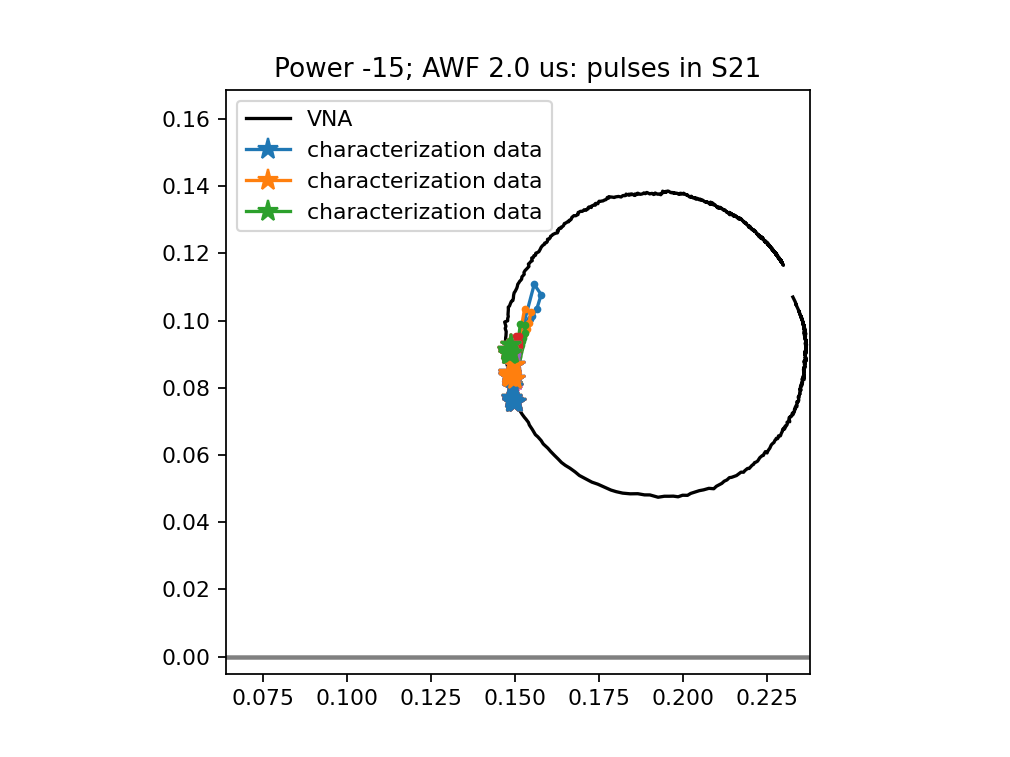

<IPython.core.display.Javascript object>


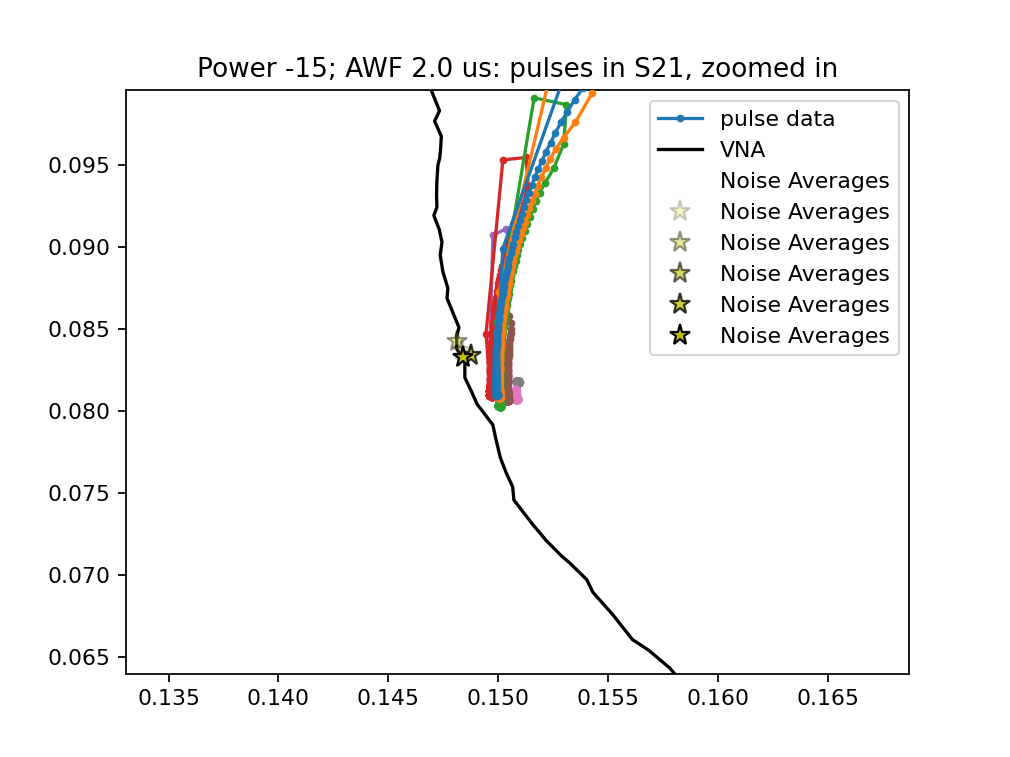

<IPython.core.display.Javascript object>


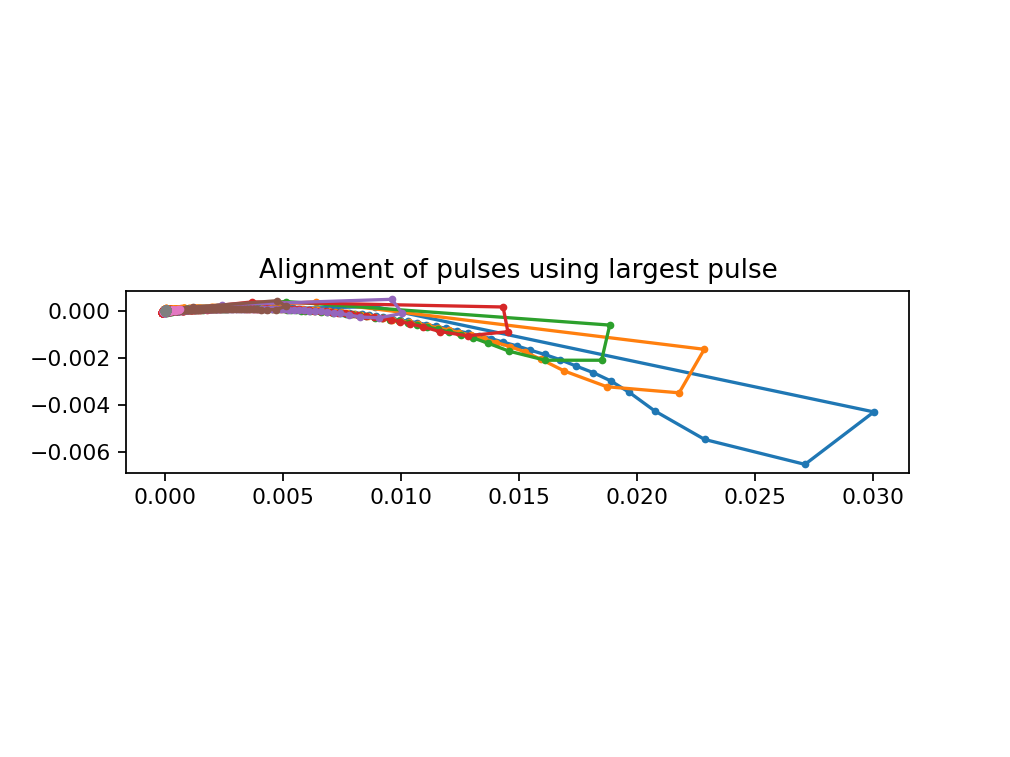

<IPython.core.display.Javascript object>


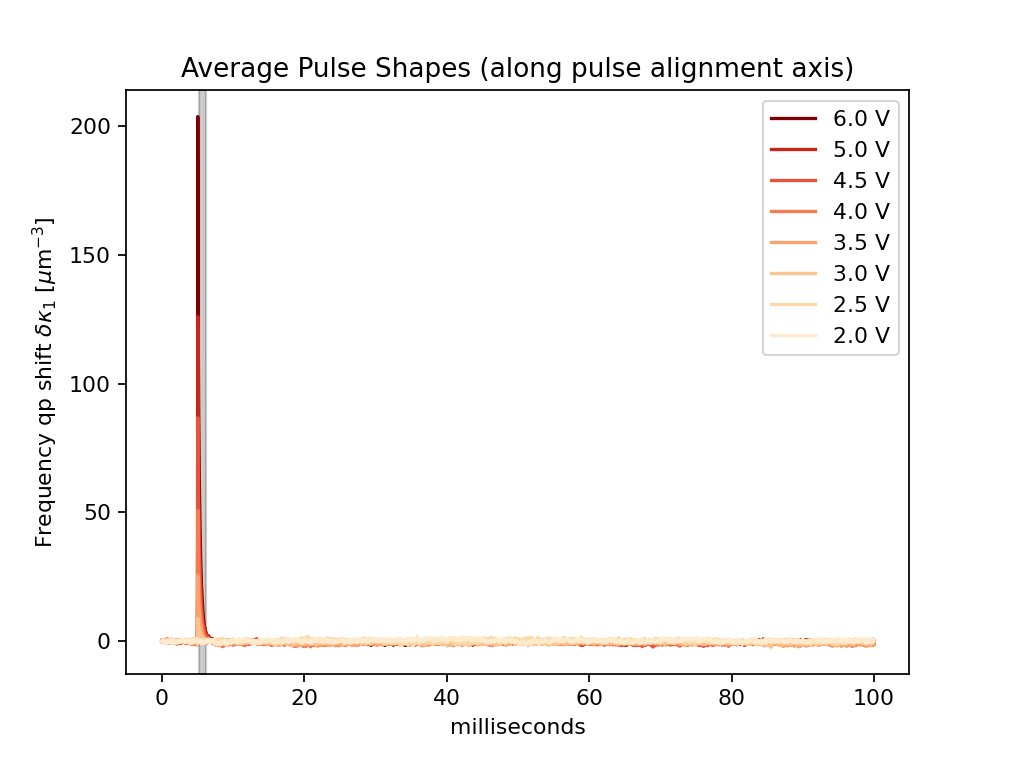

<IPython.core.display.Javascript object>


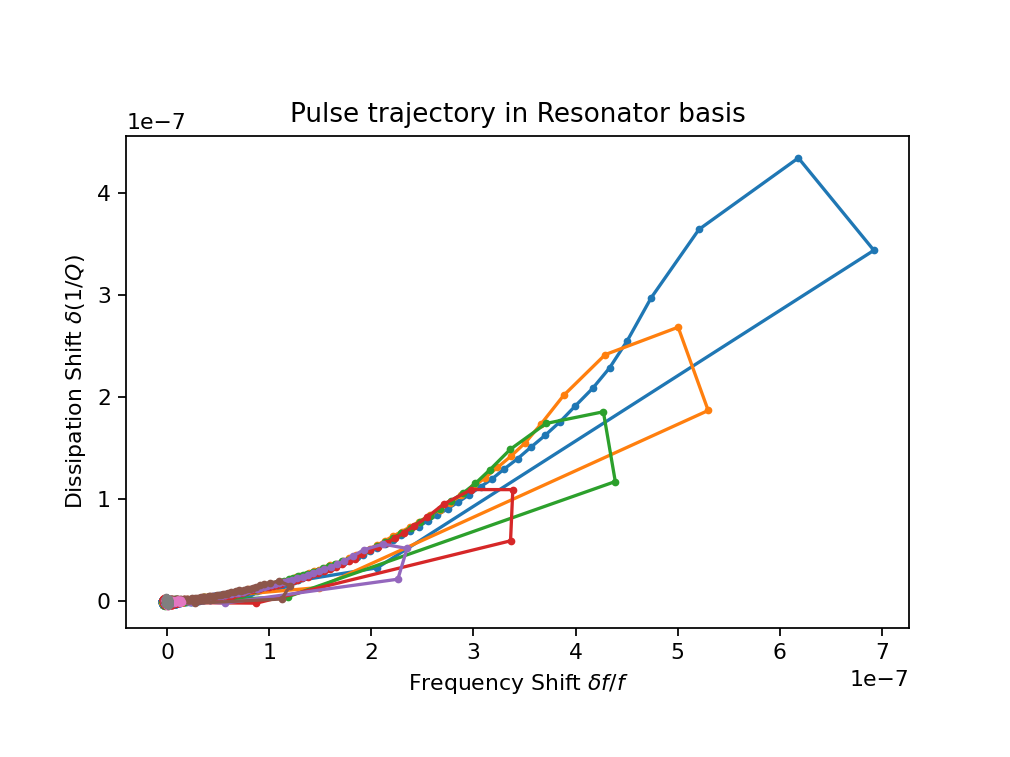

<IPython.core.display.Javascript object>


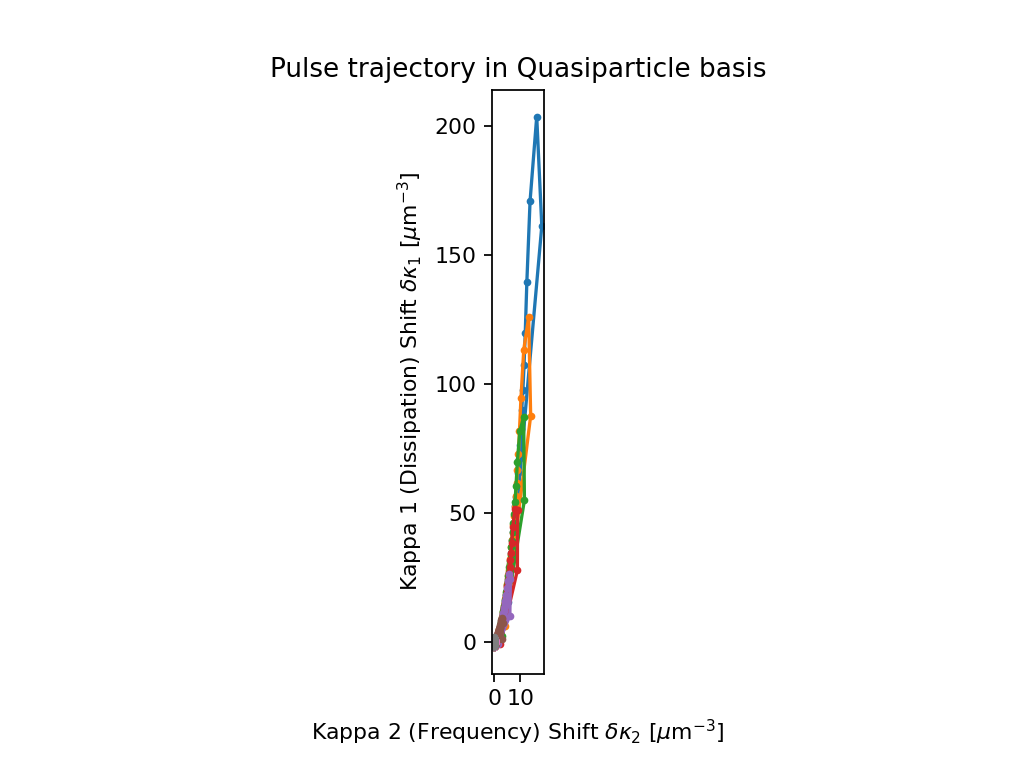

cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using summary file:  /data/USRP_Laser_Data/20230713/20230713_152558/noise_averages_20230713_152558.h5
Fr from fit  [GHz]: 4.24195154162525
Fr min curve [GHz]: 4.241951646175839
Fr from fit  [GHz]: 4.24195154162525
Fr min curve [GHz]: 4.241951646175839
Using dk1 (qp-dissipation) readout
Saving clean pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_5.000V_20230713_152558_cleaned.h5
cleaning pulse file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_4.500V_20230713_152558.h5
using VNA file:      /data/USRP_Laser_Data/20230713/20230713_152558/USRP_VNA_20230713_152558.h5
using summary file:  /data/USRP_Laser_Data/20230713/20230713_152558/noise_averages_20230713_152558.h5
Fr from fit  [GHz]: 4.24195154162525
Fr min curve [GHz]: 4.241951646175839
Fr from fit

In [28]:
max_pls_heights = oft.align_all_pulses(LED_files, nse_files, vna_file, sum_file, p_params, charFs, charZs, MB_fit_vals, Voltages,
                     fraction_to_keep=0.5, tw_min_us=5.25e3, tw_max_us=6.25e3, data_T_K=10.0e-3,
                     readout_unit=readout)

In [19]:
## Number of seconds by which to shift the window when calculating J
window_shift_J = 0 # -8.0e-3 # -10e-6 #

## Define a maximum frequency for the fourier-space mask
f_max = 1e4 ## Hz maximum freq in fourier space

Using file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558.h5 as pulse template
5000 samples per window


<IPython.core.display.Javascript object>


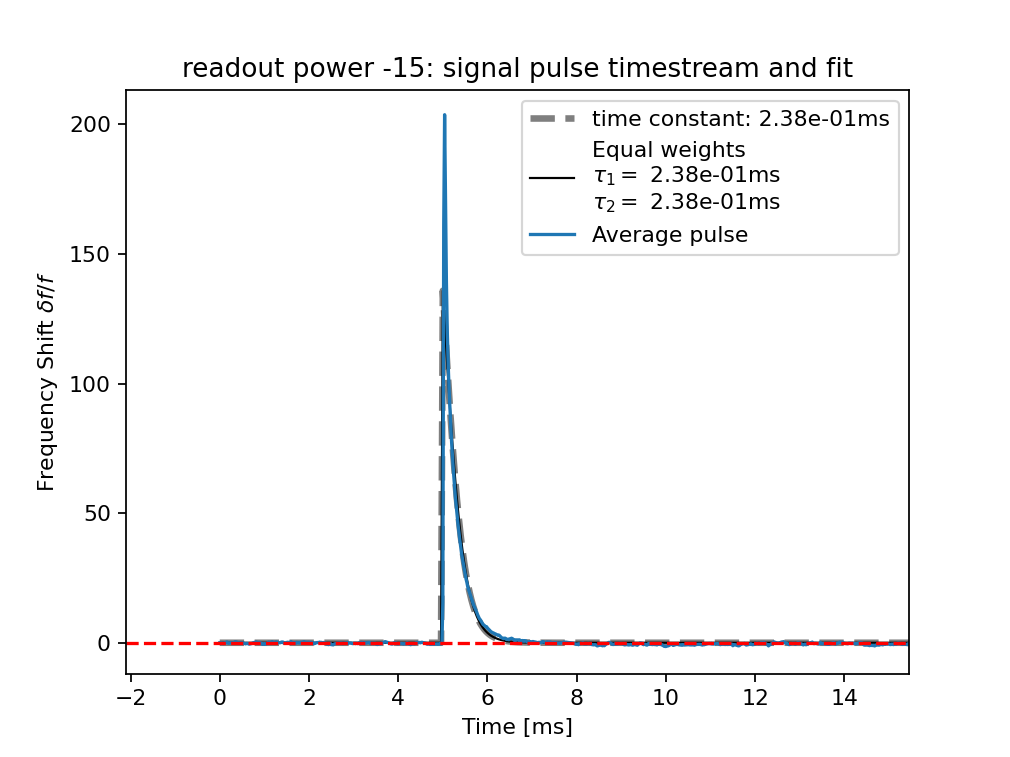

<IPython.core.display.Javascript object>


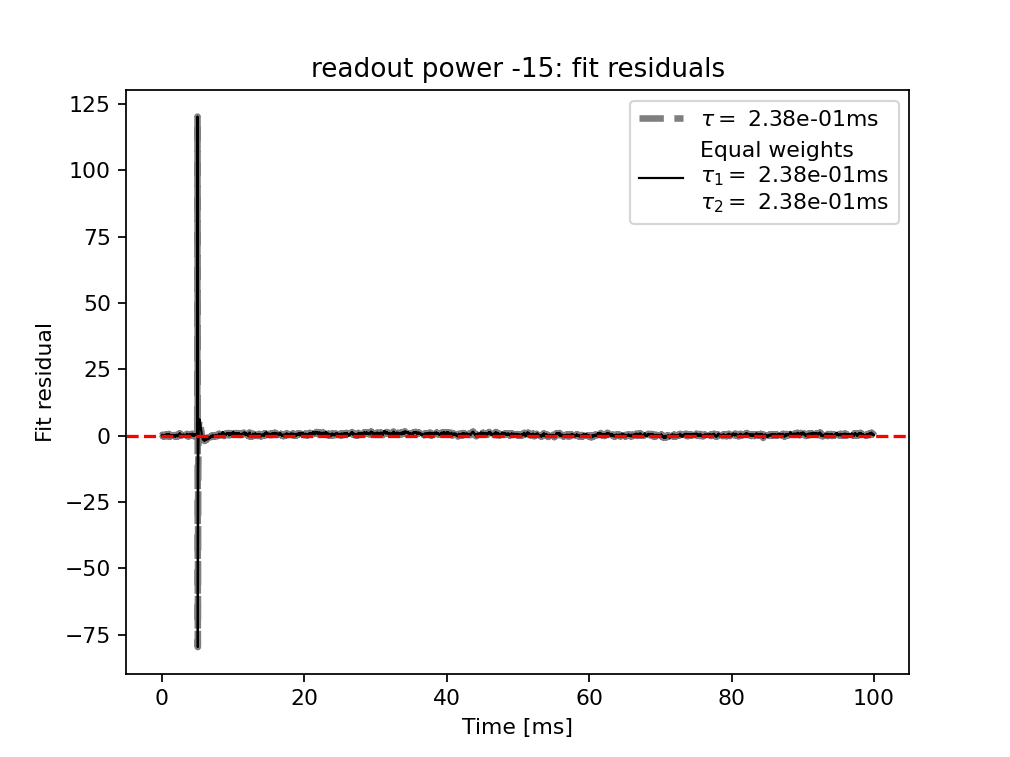

In [20]:
# ## Pick the highest LED voltage data to use as signal template
S_mag, s, A = oft.get_pulse_template(LED_files[-1], p_params, 
                               window_shift_J=window_shift_J, f_max=f_max, use_fit_as_template=False)

Using file: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_2.000V_20230713_152558.h5 to characterize noise
5000 samples per window
Baseline resolution: 0.024587726973304063


<IPython.core.display.Javascript object>


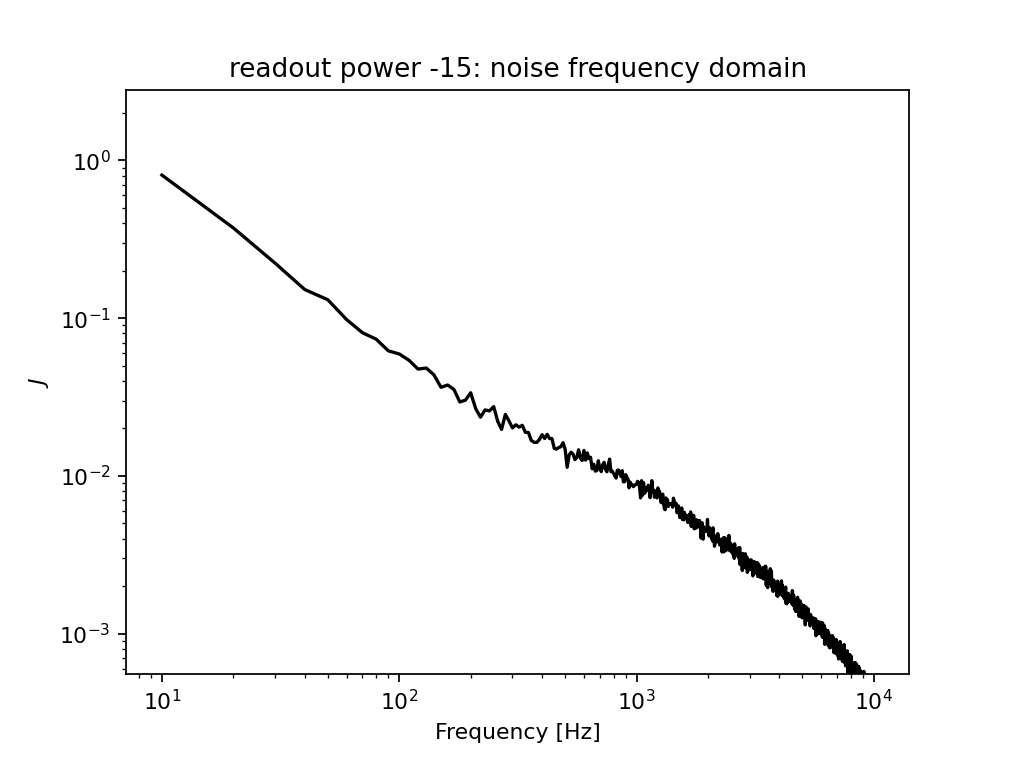

<IPython.core.display.Javascript object>


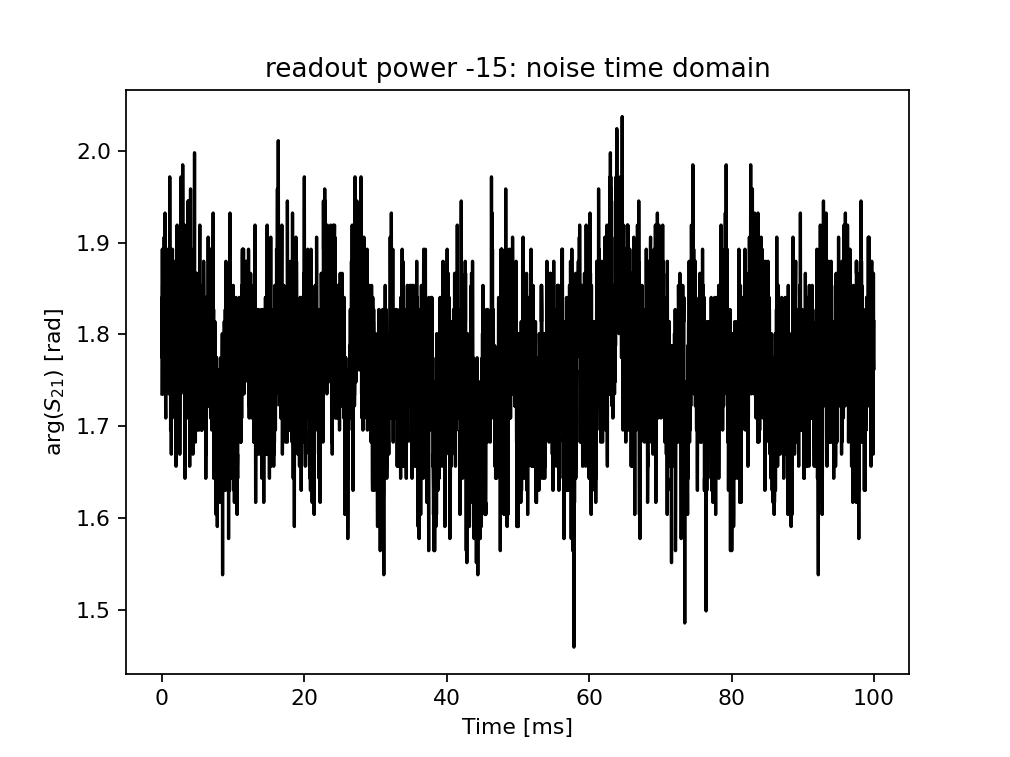

In [21]:
## Pick the lowest LED voltage data to use as noise template
J_avg, denominator, b7_res = oft.get_noise_template(LED_files[0], s, p_params, bad_pls_idxs, 
                                                    window_shift_J=window_shift_J, f_max=f_max,
                                                    PHASE=PHASE)

In [22]:
print("Using", readout, "direction readout")
print("Signal template from:", LED_files[-1])
print("Maximum pulse height:", max_pls_heights[LED_files[-1]])
print("Baseline resolution from noise (normalized):", b7_res)
print("Baseline resolution in readout units:",b7_res*max_pls_heights[LED_files[-1]])

Using dk1 direction readout
Signal template from: /data/USRP_Laser_Data/20230713/20230713_152558/USRP_LaserOn_6.000V_20230713_152558.h5
Maximum pulse height: 203.68695317546957
Baseline resolution from noise (normalized): 0.024587726973304063
Baseline resolution in readout units: 5.008199192702615


In [23]:
MBe.beta(10.0e-3, MB_fit_vals[0], MB_fit_vals[1])

8355407.665081458